<a href="https://colab.research.google.com/github/my000own000files1/nonlinear_and_adaptive_control_systems/blob/main/kurs_var805.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Вариант 805

Система управления разрабатывается для обеспечения желаемого уровня напряжения на клеммах системы накопления
энергии. В объекте управления имеется 2 датчика и один исполнительный механизм:
* амперметр системы накопления энергии
* вольтметр системы накопления энергии
* электронный компонент, регулирующий напряжение заряда

# 1.Модель системы

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ubtanh(7)+tanh(9)}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30tanh(Uc)-8$

где $Ib$ - ток через систему накопления энергии, $Ub$ - напряжение на клеммах системы накопления энергии, $Uc$ - сила напряжения управляющего элемента, $dUb_0 \in [8;19]$ - неконтролируемое возмущение в системе.

В качестве переменной управления выступает сила напряжения управляющего элемента $Uc$. Управляемой величиной является напряжение на клеммах системы накопления энергии $Ub$.

Используя программные средства языка программирования Python, промоделируем поведение системы при следующих параметрах:

$U_c = 0$

$Ub_0 = 20, Ib_0 = 5$, 

где $Ub_0$ и $Ib_0$ - начальные условия

то есть при ненулевых начальных условиях и с нулевым управлением.


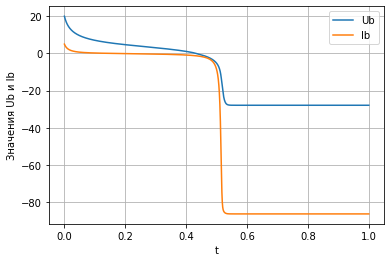

Ubust= -27.857508661587133 ,     Ibust= -86.27425198621056


In [ ]:
import matplotlib.pyplot as plt 
import scipy.integrate as mdl 
import math
import numpy as np

Uc = 0
dUb0 = 0
def F(x, t):
    Ub=x[0]
    Ib=x[1]
    return [25*Ib-0.1*math.pow(Ub,3)+dUb0-3*math.exp(-7*math.pow(Ub,2)+Ub*math.tanh(7)+math.tanh(9))-5,
            -0.1*math.pow(Ib,3)-8*math.pow(Ib,2)-2*Ib*Ub-2*Ib+Ub+30*math.tanh(Uc)-8] 

t = np.linspace(0, 1, 10000)    # задаем сетку времени
y = mdl.odeint(F, [20.0, 5.0], t) # решаем дифф.уравнения

plt.plot(t,y) # y - состоит из двух столбцов
plt.grid()
plt.xlabel('t')
plt.ylabel('Значения Ub и Ib')
plt.legend(['Ub','Ib'])
plt.show()
print("Ubust=",y[len(y)-1][0],",    ","Ibust=",y[len(y)-1][1])

Моделирование показало, что при выбранных параметрах система является устойчивой. При этом установившееся значение координат не равно нулю.

Теперь промоделируем систему при нулевых начальных условиях и с максимально возможным значением управления. Проверим максимально возможное значение достигаемое управляемой координатой.

$U_c = 10$

$Ub_0 = 0, Ib_0 = 0$, 

где $Ub_0$ и $Ib_0$ - начальные условия

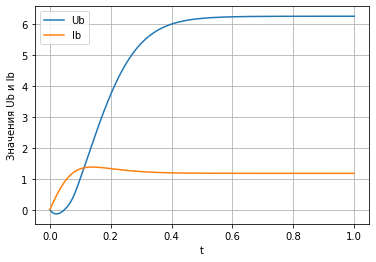

In [ ]:
Uc = 10
dUb0 = 0
def F(x, t):
    Ub=x[0]
    Ib=x[1]
    return [25*Ib-0.1*math.pow(Ub,3)+dUb0-3*math.exp(-7*math.pow(Ub,2)+Ub*math.tanh(7)+math.tanh(9))-5,
            -0.1*math.pow(Ib,3)-8*math.pow(Ib,2)-2*Ib*Ub-2*Ib+Ub+30*math.tanh(Uc)-8] 

t = np.linspace(0, 1, 10000)    # задаем сетку времени
y = mdl.odeint(F, [0.0, 0.0], t) # решаем дифф.уравнения

plt.plot(t,y) # y - состоит из двух столбцов
plt.grid()
plt.xlabel('t')
plt.ylabel('Значения Ub и Ib')
plt.legend(['Ub','Ib'])
plt.show()
#
#
#
#
#

Можем видеть максимальные значение для $Ub=6.5$ , а для $Ib=1.25$.

# 2.Моделирование САУ с цифровым ПИ-регулятором

Следующим шагом проведем моделирование исходной системы с добавление цифрового ПИ-регулятора. Для этого также используем программные средства языка Python.

Базовый класс для моделирования контроллера

In [ ]:
import math
import numpy

class PLC:
    def __init__(self, gain, step):
        self.last_t = 0.0
        self.last_call_t = 0.0
        self.last_u = 0
        self.step = step
        self.last_e = 0.0
        self.gain = gain
        self.u = []
        self.ulim = []
        self.t = []
        
    def getLimitedOutput(self,value):
        return math.tanh(value)
        
    def addOutputValue(self,time,value):
        self.t.append(time)
        self.u.append(value)
        self.ulim.append(self.getLimitedOutput(value))
        
    def output(self, x, t):
        self.addOutputValue(t, self.last_u)
        self.last_u = self.control(x, t)
        self.last_t = t
        self.addOutputValue(t,self.last_u)
        
        return self.gain*self.ulim[-1]

def calculate(func, x0, step, time, plc):
    result = {'t': [], 'u':[]}
    for i in range(0,len(x0)):
        result['x' + str(i + 1)] = []
    rstep = plc.step
    ode_step = step
    timev = numpy.linspace(0.0, time, int(time/rstep+1))
    for ti in timev:
        uk = plc.output(x0, ti)
        tk = np.linspace(ti, ti+rstep, int(rstep/ode_step+1))
        y = mdl.odeint(func(uk), x0, tk)
        x0 = y[-1]
        result['t'].extend(tk[:-1])
        for i in range(0,len(x0)):
            result['x' + str(i + 1)].extend(y[:-1,i])
        result['u'].extend([uk for i in tk[:-1]])
    return result

Для имитации изменения неконтроллируемого возмущения в описание уравнений системы добавим ступенчатое изменение значения возмущения $dUb0$. В момент времени, заданного в переменной step_time происходит изменение значения переменной $dUb0$ со значения **init_value** до **finish_value**.

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ubtanh(7)+tanh(9)}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30tanh(Uc)-8$

In [ ]:
def F_with_change(step_time, init_value, finish_value):
    def F_with_control(uc): # тут получаем сигнал управления
        def F_internal(x, t): # возвращает правую часть системы ДУ
            Ub=x[0]
            Ib=x[1]
            if t > step_time: # в step_time переключаем параметр 
                dUb0 = finish_value
            else:
                dUb0 = init_value
            return [25*Ib-0.1*math.pow(Ub,3)+dUb0-3*math.exp(-7*math.pow(Ub,2)+Ub*math.tanh(7)+math.tanh(9))-5, -0.1*math.pow(Ib,3)-8*math.pow(Ib,2)-2*Ib*Ub-2*Ib+Ub+uc-8] 
    
        return F_internal
    return F_with_control

Реализация алгоритма ПИ-регулирования

In [ ]:
class PI(PLC):
    def __init__(self, goal, Kp, Ki, gain, step):
        super(PI,self).__init__(gain, step)
        self.Ki = Ki 
        self.Kp = Kp
        self.goal = goal # задание
        self.ei = 0 # ошибка интегрирования
    
    def control(self, x, t):
        e = x[0] - self.goal # cчитаем разницу между текущим значением переменной и заданием
        self.ei = self.ei + e  # копим ошибку     
        return self.Kp * e + self.Ki * self.ei # возвращаем сигнал управления ПИ-регулятора

Вывод результатов моделирования


In [ ]:
def plot_result(time, time_end, x1, x2, plc, goal):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.grid()
    plt.xlim(0, time_end)
    plt.xlabel('t')
    plt.ylabel('Значения Ub и Ib')
    plt.plot(time,x1, 'r-', time, x2, 'b-') # строим график переменных ДУ
    plt.legend(['Ub','Ib'])
    plt.plot([0, time_end], [goal, goal], color='#FF0000',linestyle='--') 
    plt.subplot(1,2,2)
    plt.grid()
    plt.xlabel('t')
    plt.xlim(0, time_end)
    plt.plot(plc.t, plc.u,'b-',plc.t, plc.ulim,'r-') # график сигнала управления и лимитированого сигнала управления
    plt.plot([0, tk], [1, 1], 'r--',[0, tk], [-1, -1], 'r--',[0, tk],[0, 0],'r:')  
    plt.ylabel('Значения Uc и Uc_lim')
    plt.legend(['Uc','Uc_lim'])
    plt.show()

Программа моделирования

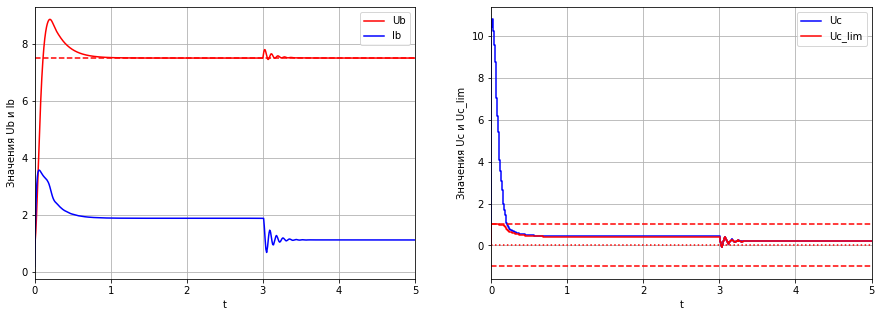

In [ ]:
v0_init = 0
v0_finish = 19
change_time = 3
goal = 7.5
gain = 150
step = 1e-2
mod_step = 1e-3
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc=PI(goal=goal, Kp=-1.5, Ki=-0.1, gain=gain, step=step) 
tk=5
x0=[1,0.2] # начальные условия
res = calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1=res['x1'], x2=res['x2'], plc=plc, goal=goal)


На первом графике представлено изменение переменных состояния системы. Пунктирной линией указано значение цели управления.
При появлении возмущения происходит срыв с задающего значения, но затем управляющее воздействие приводит систему снова к целевому значнию. Таким образом проявляется адаптивность системы.

На втором графике изображено изменение управляющего воздействия, а также обозначены границы рабочего диапазона исполнительного механизма.
Также видно, что управление за пределы допустимого рабочего диапазона.

После перебора различных вариантов ПИ-регулятора были найдены наиболее подходящие с точки зрения качества переходной характеристики. Таким образом, можно установить, что исследуемая модель системы поддается регулированию посредством ПИ-регулятора.



# 3.Автоматизация расчета закона управления с помощью пакета sympy

Данный шаг предполагает расчет функции управления по методу АКАР с использование пакета символьных вычислений sympy.

Для этого необходимо ввести в программу исходную систему уравнений системы с использованием символьных переменных.

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ubtanh(7)+tanh(9)}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30tanh(Uc)-8$


**-----------------------** 

Для дальнейшего моделирования можно приближённо  $tanh(Uc)$ заменить на $Uc$ по той причине, что символьные вычисления некорректно работают с $tanh$.

Тогда:

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ub+1}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30Uc-8$

In [ ]:
import sympy,math
#создаем символьные переменные
Ub=sympy.symbols('Ub')
Ib=sympy.symbols('Ib')
dUb0=sympy.symbols('dUb0')
Uc=sympy.symbols('Uc')
#записываем уравнения
dUb = 25*Ib-0.1*Ub**3+dUb0-3*sympy.exp(-7*Ub**2+Ub+1)-5
dIb = -0.1*Ib**3-8*Ib**2-2*Ib*Ub-2*Ib+Ub+30*Uc-8

print('Уравнения системы:')
print('dUb/dt=' + str(dUb))
print('dIb/dt=' + str(dIb))
print('')

Уравнения системы:
dUb/dt=25*Ib - 0.1*Ub**3 + dUb0 - 3*exp(-7*Ub**2 + Ub + 1) - 5
dIb/dt=-0.1*Ib**3 - 8*Ib**2 - 2*Ib*Ub - 2*Ib + Ub + 30*Uc - 8



Суть метода АКАР заключается в последовательно декомпозиции исходной системы от внутренних переменных объекта до внешних переменных управления. Рассмотрим нашу систему в качестве следующей цепочки влияния переменных:

$Ub \leftarrow Ib \leftarrow U_c$

Таким образом, необходимо последовательно "раскрывать" систему от управляемой величины $Ub$ до управляющего воздействия $U_c$, путем формирования целевых функций макропеременных и моделей движения до них.

Итогом метода АКАР является формирование функции управления объектом.

Сформируем эталонную модель: 

$\dot Ub_d = Ub_d - Ub$,

Для поиска управления приравняем ихсодную и эталонную модели:

$\dot Ub - \dot Ub_d = 0$,

где $Ub_d$ - желаемое напряжение


In [ ]:
from sympy.solvers import solve
Ubd=sympy.symbols('Ubd')
DdUb=Ubd-Ub # определяем желаемую функцию изменения Ub
DIb=solve(dUb-DdUb,Ib) 
print('Желаемая функция DIb(t) для эталонной модели DdIb='+str(DdUb))
print('DIb='+str(DIb[0].evalf(2))) # DIb - функция, при которой Ub ведет себя как нам нужно
print('')


Желаемая функция DIb(t) для эталонной модели DdIb=-Ub + Ubd
DIb=0.004*Ub**3 - 0.04*Ub + 0.04*Ubd - 0.04*dUb0 + 0.33*exp(-7.0*Ub**2 + Ub) + 0.2



Для расчета функции управления по методу АКАР, необходимо составить целевую функцию $Psi$. 

В общем виде: $Psi=Psi(Ub,Ib)$

$Psi=DIb-Ib$

Эталонная модель движения к Psi:

$Psi+\dot Psi=0$ (1) $\rightarrow$ устойчива относительо ед.положения равновесия $Psi=0$.

Из уравнения (1) можно аналитически найти функцию  управления $Uc$. 
Общий вид $Uc=Uc(Ub,Ubd,dUb0,Ib)$

Применяя все выше сказанное, к нашей модели получим:

In [ ]:
psi=DIb[0]-Ib # оперделяем функцию Psi
dpsi=sympy.diff(psi,Ub)*dUb + sympy.diff(psi,Ib)*dIb # расчет полной производной по времени
u=solve(dpsi+psi,Uc) # находим функцию управленияя
u_analytical = sympy.expand(u[0])
print('Закон управления по методу АКАР для макропеременной psi=' + str(psi))
print('Uc='+str(u_analytical.evalf(2)))
print('')

u_AKAR=u_analytical #для идентификации

Закон управления по методу АКАР для макропеременной psi=-Ib + 0.004*Ub**3 - 0.04*Ub + 0.04*Ubd - 0.04*dUb0 + 0.326193819415085*exp(-7.0*Ub**2 + Ub) + 0.2
Uc=0.0033*Ib**3 + 0.27*Ib**2 + 0.01*Ib*Ub**2 - 3.8*Ib*Ub*exp(1.0*Ub)*exp(-7.0*Ub**2) + 0.067*Ib*Ub + 0.27*Ib*exp(1.0*Ub)*exp(-7.0*Ub**2) - 4.0e-5*Ub**5 + 0.015*Ub**4*exp(1.0*Ub)*exp(-7.0*Ub**2) - 0.0011*Ub**3*exp(1.0*Ub)*exp(-7.0*Ub**2) + 0.00027*Ub**3 + 0.0004*Ub**2*dUb0 - 0.0033*Ub**2*exp(Ub)*exp(-7.0*Ub**2) - 0.002*Ub**2 - 0.15*Ub*dUb0*exp(1.0*Ub)*exp(-7.0*Ub**2) + 0.76*Ub*exp(1.0*Ub)*exp(-7.0*Ub**2) + 1.2*Ub*exp(2.0*Ub)*exp(-14.0*Ub**2) - 0.035*Ub + 0.0013*Ubd + 0.011*dUb0*exp(1.0*Ub)*exp(-7.0*Ub**2) - 0.0027*dUb0 - 0.044*exp(1.0*Ub)*exp(-7.0*Ub**2) + 0.011*exp(Ub)*exp(-7.0*Ub**2) - 0.089*exp(2.0*Ub)*exp(-14.0*Ub**2) + 0.28



In [ ]:
#парсер в нужный формат Latex
def pars_Tex(u_str):
    import string
    u_str=str(u_str.evalf(2))
    u_str=u_str.replace("**","^")
    # замена ** на math.pow()
    n_z=u_str.find("exp")
    while n_z != (-1):
        n_frl = u_str.find(")",n_z)#индекс первой попавшейся скобки ")"\
        n_ll=u_str.count("(",n_z+4,n_frl) #кол-во не закрытых скобок "("
        n_lll=u_str.find("(",n_z+4,n_frl)#индекс последней незакрытой скобки "(" (last left line)
        while n_ll > 0: #есть незакрытые скобки  
            n_frl = u_str.find(")",n_frl+1) #переходим к индексу следующей скобки ")"
            n_ll=u_str.count("(",n_lll+1,n_frl) #обновляем количество незакрытых скобок "(", тем самым приблежаясь к концу строки
            n_lll=u_str.find("(",n_lll+1,n_frl)#переход к индексу следующей скобки "("
        u_str = u_str[0:n_z] + "e^{" + u_str[n_z+4:n_frl] + "}" + u_str[n_frl+1:]
        n_z=u_str.find("exp",n_z+1)  
    print(u_str)


In [ ]:
pars_Tex(u_analytical)

0.0033*Ib^3 + 0.27*Ib^2 + 0.01*Ib*Ub^2 - 3.8*Ib*Ub*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.067*Ib*Ub + 0.27*Ib*e^{1.0*Ub}*e^{-7.0*Ub^2} - 4.0e-5*Ub^5 + 0.015*Ub^4*e^{1.0*Ub}*e^{-7.0*Ub^2} - 0.0011*Ub^3*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.00027*Ub^3 + 0.0004*Ub^2*dUb0 - 0.0033*Ub^2*e^{Ub}*e^{-7.0*Ub^2} - 0.002*Ub^2 - 0.15*Ub*dUb0*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.76*Ub*e^{1.0*Ub}*e^{-7.0*Ub^2} + 1.2*Ub*e^{2.0*Ub}*e^{-14.0*Ub^2} - 0.035*Ub + 0.0013*Ubd + 0.011*dUb0*e^{1.0*Ub}*e^{-7.0*Ub^2} - 0.0027*dUb0 - 0.044*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.011*e^{Ub}*e^{-7.0*Ub^2} - 0.089*e^{2.0*Ub}*e^{-14.0*Ub^2} + 0.28


Таким образом, функция аналитического управления переменной I выглядит следующим образом:

 $Uc=0.0033*Ib^3 + 0.27*Ib^2 + 0.01*Ib*Ub^2 - 3.8*Ib*Ub*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.067*Ib*Ub + 0.27*Ib*e^{1.0*Ub}*e^{-7.0*Ub^2} - 4.0e-5*Ub^5 + 0.015*Ub^4*e^{1.0*Ub}*e^{-7.0*Ub^2} - 0.0011*Ub^3*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.00027*Ub^3 + 0.0004*Ub^2*dUb0 - 0.0033*Ub^2*e^{Ub}*e^{-7.0*Ub^2} - 0.002*Ub^2 - 0.15*Ub*dUb0*e^{1.0*Ub}*e^{-7.0*Ub^2} + 0.76*Ub*e^{1.0*Ub}*e^{-7.0*Ub^2} + 1.2*Ub*e^{2.0*Ub}*e^{-14.0*Ub^2} - 0.035*Ub + 0.0013*Ubd + 0.011*dUb0*e^{1.0*Ub}*e^{-7.0*Ub^2} - 0.0027*dUb0 + 0.011*e^{Ub}*e^{-7.0*Ub^2} - 0.044*e^{1.0*Ub}*e^{-7.0*Ub^2} - 0.089*e^{2.0*Ub}*e^{-14.0*Ub^2} + 0.28$


# 4.Моделирование САУ с аналитическим регулятором

Используем полученную на предыдущем шаге функцию управления.

In [ ]:
#парсер в нужный формат для подстановки в контроллер
def pars_control(u_str):
    import string
    u_str=str(u_str.evalf(2))
    u_str=u_str.replace("Ubd","self.Ubd")
    u_str=u_str.replace("dUb0","self.dUb0")
    u_str=u_str.replace("exp","math.exp")
    u_str=u_str.replace("G","self.G")
    # замена ** на math.pow()
    n_z=u_str.find("**")
    while n_z != (-1):
        u_str = u_str[0:n_z-2] + "math.pow(" + u_str[n_z-2:n_z] + "," + u_str[n_z+2:n_z+3] + ")" + u_str[n_z+3:]
        n_z=u_str.find("**",n_z+1)  
    print(u_str)


In [ ]:
pars_control(u_analytical)

0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.00027*math.pow(Ub,3) + 0.0004*math.pow(Ub,2)*self.dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*self.dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.035*Ub + 0.0013*self.Ubd + 0.011*self.dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0027*self.dUb0 - 0.044*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.28


Программа моделирования. 
Функция $control$ рассчитывает значение сигнала управления по синтезированному закону управления. 
Так как в формулу входит неконтролируемое возмущение, то необходимо его учесть. Условно считая, что оно является случайной велечиной с нормальным распредлением, с медианой в середине интервала, выберем среднее значение помехи.

In [ ]:
class AKAR(PLC):
    def __init__(self, goal, gain, dtu):
        super(AKAR,self).__init__(gain, dtu)
        self.dUb0 = 13.5 # середина диапазона неконтроллируемого возмущения
        self.Ubd=goal # желаемое значение температуры в помещении
    
    def control(self, x, t):
        Ub=x[0]
        Ib=x[1]
        return 0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.00027*math.pow(Ub,3) + 0.0004*math.pow(Ub,2)*self.dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*self.dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.035*Ub + 0.0013*self.Ubd + 0.011*self.dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0027*self.dUb0 + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.044*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.28

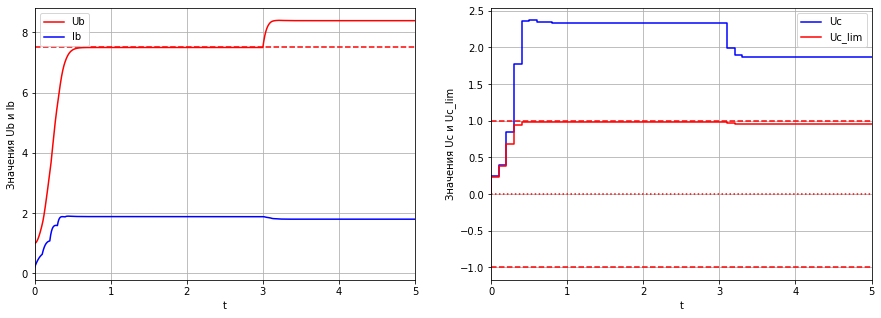

In [ ]:
v0_init = 0
v0_finish = 19
change_time = 3
goal = 7.5
gain=62.9
step = 1e-1
mod_step = 1e-3
tk = 5
x0 = [1.0, 0.2]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

plc = AKAR(goal=goal, gain=gain, dtu=step)
res = calculate(func_ctrl, x0, mod_step, tk, plc)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=plc, goal=goal)

По графику изменения управляемой координаты видно, что переходный процесс более плавный, но время переходного процесса больше, чем у ПИ-регулятора. Также появилась статическая ошибка регулирования. При появлении возмущения эта ошибка возрастает пропорционально величине возмущения.

Также преимуществом стало то, что при уменьшении частоты регулятора на порядок качество переходного процесса не ухудшилось.

# 5.САУ с аналитическим регулятором и интегральной компонентой

В данном разделе используется раннее изученный метод АКАР. Отличием от раздела 4 является добавление промежуточной целевой функции, содержащей интегральную компоненту $z$. 
Целью введения интегральной компоненты является желание уменьшить значение статистической ошибки управления.

Уравнения системы:

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ubtanh(7)+tanh(9)}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30tanh(Uc)-8$

Функции макропеременных:

$\psi_1 = Ubd - Ub$

$\psi_2 = \psi_1 + z = Ubd - Ub + z$

$\psi_3 = DIb - Ib$

Эталонные модели:

$T_1 \dot \psi_2 + \psi_2 = 0$

$T_3 \dot \psi_3 + \psi_3 = 0$

Интегральная компонента:

$\dot z = \frac 1 {T_2} \psi_1$ 

Параметр $dUb0$ (возмущение):

$dUb0 = dUb0_{min} + \frac{(dUb0_{max}-dUb0_{min})}{2}=13.5$



Заметим, что синтезированный закон управления содержит в явном виде интегральную компоненту $z$.

In [ ]:
import sympy
from sympy.solvers import solve

Ub = sympy.symbols('Ub')
Ib = sympy.symbols('Ib')
Uc = sympy.symbols('Uc')
z = sympy.symbols('z')
Ubd = sympy.symbols('Ubd')
dUb0 = sympy.symbols('dUb0')
T_1 = sympy.symbols('T_1')
T_2 = sympy.symbols('T_2')
T_3 = sympy.symbols('T_3')

#записываем уравнения
dUb = 25*Ib-0.1*Ub**3+dUb0-3*sympy.exp(-7*Ub**2+Ub+1)-5
dIb = -0.1*Ib**3-8*Ib**2-2*Ib*Ub-2*Ib+Ub+30*Uc-8

psi_1 = Ub - Ubd# 1 функция макропеременных
psi_2 = psi_1 + z # 2 функция макропеременных
dz = 1/T_2*psi_1 # интегральная компонента
dpsi_2 = sympy.diff(psi_2, Ub)*dUb + sympy.diff(psi_2, z)*dz # расчет полной производной по времени
DIb = solve(sympy.expand(T_1*dpsi_2 + psi_2),Ib) # ищем желаемый вид DIb
print(f'dz = {dz}')
print(f'DIb = {str(DIb[0].evalf(2))}')
psi_3 = DIb[0] - Ib # 3 функция макропеременных
dpsi_3 = sympy.diff(psi_3,Ub)*dUb + sympy.diff(psi_3,Ib)*dIb + sympy.diff(psi_3,z)*dz # расчет полной производной по времени для пси3
u = solve(sympy.expand(T_3*dpsi_3 + psi_3),Uc) # находим функцию управления
u_analytical = sympy.expand(u[0]).evalf(2)
print(f'psi_2 = {str(psi_2)}')
print(f'Uc = {str(u_analytical)}')

dz = (Ub - Ubd)/T_2
DIb = 0.004*Ub**3 - 0.04*dUb0 + 0.33*exp(Ub)*exp(-7.0*Ub**2) + 0.2 - 0.04*Ub/T_2 + 0.04*Ubd/T_2 - 0.04*Ub/T_1 + 0.04*Ubd/T_1 - 0.04*z/T_1
psi_2 = Ub - Ubd + z
Uc = 0.0033*Ib**3 + 0.27*Ib**2 + 0.01*Ib*Ub**2 - 3.8*Ib*Ub*exp(Ub)*exp(-7.0*Ub**2) + 0.067*Ib*Ub + 0.27*Ib*exp(Ub)*exp(-7.0*Ub**2) + 0.067*Ib - 0.033*Ib/T_3 - 0.033*Ib/T_2 - 0.033*Ib/T_1 - 4.0e-5*Ub**5 + 0.015*Ub**4*exp(Ub)*exp(-7.0*Ub**2) - 0.0011*Ub**3*exp(Ub)*exp(-7.0*Ub**2) + 0.0004*Ub**2*dUb0 - 0.0033*Ub**2*exp(Ub)*exp(-7.0*Ub**2) - 0.002*Ub**2 - 0.15*Ub*dUb0*exp(Ub)*exp(-7.0*Ub**2) + 0.76*Ub*exp(Ub)*exp(-7.0*Ub**2) + 1.2*Ub*exp(2.0*Ub)*exp(-14.0*Ub**2) - 0.033*Ub + 0.011*dUb0*exp(Ub)*exp(-7.0*Ub**2) - 0.054*exp(Ub)*exp(-7.0*Ub**2) - 0.089*exp(2.0*Ub)*exp(-14.0*Ub**2) + 0.27 + 0.00013*Ub**3/T_3 - 0.0013*dUb0/T_3 + 0.011*exp(1.0*Ub)*exp(-7.0*Ub**2)/T_3 + 0.0067/T_3 + 0.00013*Ub**3/T_2 - 0.0013*dUb0/T_2 + 0.011*exp(Ub)*exp(-7.0*Ub**2)/T_2 + 0.0067/T_2 - 0.0013*Ub/(T_2*T_3) + 0.0013*Ubd/(T_2*T_3) + 0.00013*U

In [ ]:
#парсер в нужный формат Latex
pars_Tex(DIb[0].evalf(2))
pars_Tex(u_analytical)


0.004*Ub^3 - 0.04*dUb0 + 0.33*e^{Ub}*e^{-7.0*Ub^2} + 0.2 - 0.04*Ub/T_2 + 0.04*Ubd/T_2 - 0.04*Ub/T_1 + 0.04*Ubd/T_1 - 0.04*z/T_1
0.0033*Ib^3 + 0.27*Ib^2 + 0.01*Ib*Ub^2 - 3.8*Ib*Ub*e^{Ub}*e^{-7.0*Ub^2} + 0.067*Ib*Ub + 0.27*Ib*e^{Ub}*e^{-7.0*Ub^2} + 0.067*Ib - 0.033*Ib/T_3 - 0.033*Ib/T_2 - 0.033*Ib/T_1 - 4.0e-5*Ub^5 + 0.015*Ub^4*e^{Ub}*e^{-7.0*Ub^2} - 0.0011*Ub^3*e^{Ub}*e^{-7.0*Ub^2} + 0.0004*Ub^2*dUb0 - 0.0033*Ub^2*e^{Ub}*e^{-7.0*Ub^2} - 0.002*Ub^2 - 0.15*Ub*dUb0*e^{Ub}*e^{-7.0*Ub^2} + 0.76*Ub*e^{Ub}*e^{-7.0*Ub^2} + 1.2*Ub*e^{2.0*Ub}*e^{-14.0*Ub^2} - 0.033*Ub + 0.011*dUb0*e^{Ub}*e^{-7.0*Ub^2} - 0.054*e^{Ub}*e^{-7.0*Ub^2} - 0.089*e^{2.0*Ub}*e^{-14.0*Ub^2} + 0.27 + 0.00013*Ub^3/T_3 - 0.0013*dUb0/T_3 + 0.011*e^{1.0*Ub}*e^{-7.0*Ub^2}/T_3 + 0.0067/T_3 + 0.00013*Ub^3/T_2 - 0.0013*dUb0/T_2 + 0.011*e^{Ub}*e^{-7.0*Ub^2}/T_2 + 0.0067/T_2 - 0.0013*Ub/(T_2*T_3) + 0.0013*Ubd/(T_2*T_3) + 0.00013*Ub^3/T_1 - 0.0013*dUb0/T_1 + 0.011*e^{Ub}*e^{-7.0*Ub^2}/T_1 + 0.0067/T_1 - 0.0013*Ub/(T_1*T_3) + 0.0013*Ubd

Закон внутреннего управления $Ibd$:

$Ibd = 0.004*Ub^3 - 0.04*dUb0 + 0.33*e^{Ub}*e^{-7.0*Ub^2} + 0.2 - 0.04*Ub/T_2 + 0.04*Ubd/T_2 - 0.04*Ub/T_1 + 0.04*Ubd/T_1 + 0.04*z/T_1$

Итоговый закон управления $Uc$:

$Uc =\frac{0.0033*Ib^3 + 0.27*Ib^2 + 0.01*Ib*Ub^2 - 3.8*Ib*Ub*e^{Ub}*e^{-7.0*Ub^2} + 0.067*Ib*Ub + 0.27*Ib*e^{Ub}*e^{-7.0*Ub^2} + 0.067*Ib - 0.033*Ib/T_3 - 0.033*Ib/T_2 - 0.033*Ib/T_1 - 4.0e-5*Ub^5 + 0.015*Ub^4*e^{Ub}*e^{-7.0*Ub^2} - 0.0011*Ub^3*e^{Ub}*e^{-7.0*Ub^2} + 0.0004*Ub^2*dUb0 - 0.0033*Ub^2*e^{Ub}*e^{-7.0*Ub^2} - 0.002*Ub^2 - 0.15*Ub*dUb0*e^{Ub}*e^{-7.0*Ub^2} + 0.76*Ub*e^{Ub}*e^{-7.0*Ub^2} + 1.2*Ub*e^{2.0*Ub}*e^{-14.0*Ub^2} - 0.033*Ub + 0.011*dUb0*e^{Ub}*e^{-7.0*Ub^2} - 0.054*e^{Ub}*e^{-7.0*Ub^2} - 0.089*e^{2.0*Ub}*e^{-14.0*Ub^2} + 0.27 + 0.00013*Ub^3/T_3 - 0.0013*dUb0/T_3 + 0.011*e^{1.0*Ub}*e^{-7.0*Ub^2}/T_3 + 0.0067/T_3 + 0.00013*Ub^3/T_2 - 0.0013*dUb0/T_2 + 0.011*e^{Ub}*e^{-7.0*Ub^2}/T_2 + 0.0067/T_2 - 0.0013*Ub/(T_2*T_3) + 0.0013*Ubd/(T_2*T_3) + 0.00013*Ub^3/T_1 - 0.0013*dUb0/T_1 + 0.011*e^{Ub}*e^{-7.0*Ub^2}/T_1 + 0.0067/T_1 - 0.0013*Ub/(T_1*T_3) + 0.0013*Ubd/(T_1*T_3) + 0.0013*z/(T_1*T_3) - 0.0013*Ub/(T_1*T_2) + 0.0013*Ubd}{(T_1*T_2)}$

In [ ]:
#парсер в нужный формат для подстановки в контроллер
pars_control(u_analytical)

0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib - 0.033*Ib/T_3 - 0.033*Ib/T_2 - 0.033*Ib/T_1 - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.0004*math.pow(Ub,2)*self.dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*self.dUb0*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.033*Ub + 0.011*self.dUb0*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.054*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.27 + 0.00013*math.pow(Ub,3)/T_3 - 0.0013*self.dUb0/T_3 + 0.011*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2))/T_3 + 

Подпрограмма для реализации нелинейного регулятора с интегральной компонентой.
Для расчета интегральной компоненты используется суммирование значений с учетом дискретизации.

In [ ]:
class AKAR_i(PLC):
    def __init__(self, goal, gain, dt, T1, T2, T3, dUb0):
        super(AKAR_i,self).__init__(gain, dt)
        self.dt = dt
        self.Ubd=goal
        self.T1 = T1
        self.T2 = T2 # постоянные времени
        self.T3 = T3
        self.dUb0 = dUb0  # неконтролируемое возмущение
        self.z = []
        self.zt = []
    
    def control(self, x, t):
        Ub = x[0]
        Ib = x[1]
        T_1 = self.T1
        T_2 = self.T2
        T_3 = self.T3 
        Ubd = self.Ubd
        dt = self.dt

        if len(self.z) < 1:
            z = 0.0
        else: #расчет интегральной компоненты (как сумма значений с учетом дискретизации)
            z = self.z[-1] + dt*(Ub-Ubd)/T_2 
        self.z.append(z)
        self.zt.append(t)
        return 0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib - 0.033*Ib/T_3 - 0.033*Ib/T_2 - 0.033*Ib/T_1 - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.0004*math.pow(Ub,2)*self.dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*self.dUb0*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.033*Ub + 0.011*self.dUb0*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.054*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.27 + 0.00013*math.pow(Ub,3)/T_3 - 0.0013*self.dUb0/T_3 + 0.011*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2))/T_3 + 0.0067/T_3 + 0.00013*math.pow(Ub,3)/T_2 - 0.0013*self.dUb0/T_2 + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2))/T_2 + 0.0067/T_2 - 0.0013*Ub/(T_2*T_3) + 0.0013*self.Ubd/(T_2*T_3) + 0.00013*math.pow(Ub,3)/T_1 - 0.0013*self.dUb0/T_1 + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2))/T_1 + 0.0067/T_1 - 0.0013*Ub/(T_1*T_3) + 0.0013*self.Ubd/(T_1*T_3) - 0.0013*z/(T_1*T_3) - 0.0013*Ub/(T_1*T_2) + 0.0013*self.Ubd/(T_1*T_2)

Моделирование и результаты.
Увеличим время моделирования для того, чтобы отследить установку значения. $T_2$ является аналогом коэффициента интегратора, а $T_1,T_3$ коэффицентами пропорциональных регуляторов в линейном ПИ-регуляторе

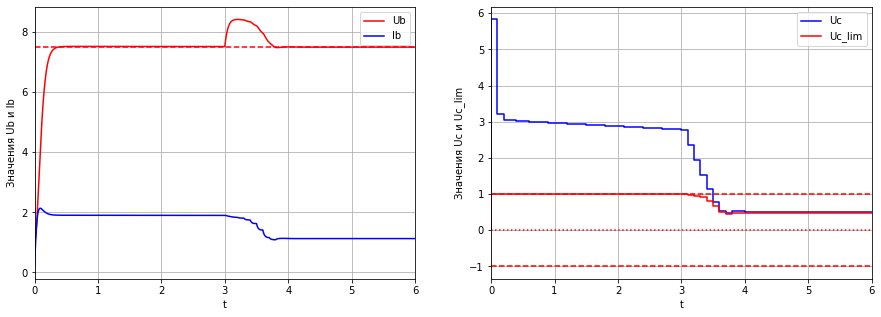

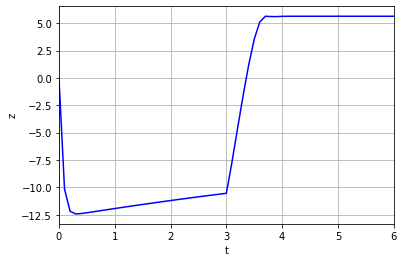

In [ ]:
tk=6
reg = AKAR_i(goal=goal, gain=gain, dt=step, T1=1e-1, T2=3e-2, T3=1e-1, dUb0=13.5)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure()
plt.plot(reg.zt, reg.z, 'b-')
plt.xlim([0.0, tk])
plt.xlabel('t')
plt.ylabel('z')
plt.grid()
plt.show()

В дополнение к имеющимся графикам добавим график изменения интегральной компоненты в процессе моделирования системы. Статическая ошибка в системе благодаря интегратору убирается колебательным переходным процессом.

При $ T2'=3e-2$ время стабилизации наилучшее, но как только мы делаем $T<T2'$ происходит резкий выход системы в автоколебательный режим.

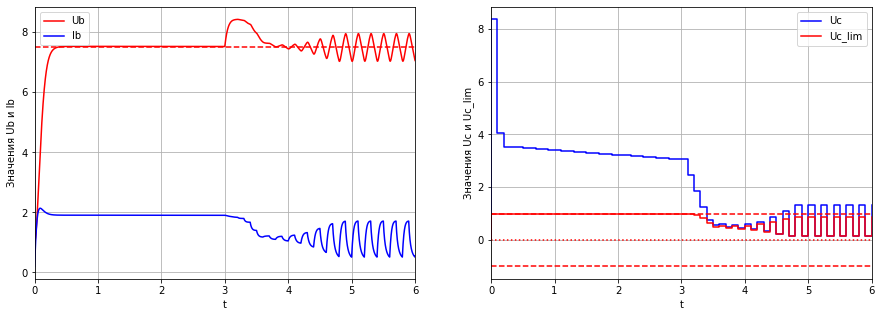

# 6.Моделирование САУ с адаптивным регулятором идентификационного типа

Целью данного раздела является построение регулятора с идентификацией. 

Как упоминалось ранее в уравнения системы присутствует компонент неконтроллируемого возмущения $dT_{20} \in [8;19]$. Этот же компонент присутствует в синтезированном законе управления по методу АКАР, найденному в разделе 3. Поэтому для того, чтобы управляющее значение было расчитано регулятором верно, необходимо идентифицировать значение неконтроллируемого возмущения.

Для идентификации значения возмущения используется модель линейной регрессии на основе исторических данных.

Первым шагом необходимо привести исходное уравнение системы к линейному виду путем замены переменных.

Уравнение системы:

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ub+1}-5$

$\dot Ub = 25Ib +  \theta \, Ub^3 + dUb0 - 3e^{-7Ub^2+Ub+1}-5, \, dUb0 \approx const$ ,

$a = \theta$

Линейный вид системы:

$y = ax + b$

Замена переменных:

$y=\dot Ub -25Ib + 3e^{-7Ub^2+Ub+1} + 5$

$x = Ub^3$ 

$a = \theta = -0.1$

$b=dUb0$

$\dot Ub_{k} \approx \frac{Ub_{k} - Ub_{{k-1}}}{\Delta t}$ - представленние производной в виде конечно разности

In [ ]:
#парсер в нужный формат для подстановки в контроллер
#берем управление из АКАР
u_str=str(u_AKAR.evalf(2))
u_str=u_str.replace("exp","math.exp")
# замена ** на math.pow()
n_z=u_str.find("**")
while n_z != (-1):
    u_str = u_str[0:n_z-2] + "math.pow(" + u_str[n_z-2:n_z] + "," + u_str[n_z+2:n_z+3] + ")" + u_str[n_z+3:]
    n_z=u_str.find("**",n_z+1)  
print("Закон управления, синтезированный по методу АКАР: \n "+u_str)


Закон управления, синтезированный по методу АКАР: 
 0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.00027*math.pow(Ub,3) + 0.0004*math.pow(Ub,2)*dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.035*Ub + 0.0013*Ubd + 0.011*dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0027*dUb0 - 0.044*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.

In [ ]:
import math
import numpy as np
import sklearn.linear_model as linmod

class ADCS_ident(PLC):
    def __init__(self, goal, gain, dt):
        super(ADCS_ident,self).__init__(gain, dt)
        self.Ubd = goal
        self.x_history = []
        self.x_history_len = 30
        self.dt = dt
        self.coeff = {'t':[0.0], 'a':[0.0], 'b':[0.0]}
        
    def transform(self, x, t):
        return [x[0], x[1], math.pow(x[0],3)]
    
    def identification(self, x, t):
        self.x_history.append(x) # сохраняем значение в историю
        if len(self.x_history) > self.x_history_len: # проверяем размер истории
            self.x_history.pop(0)
        if len(self.x_history) > 1:
            z = np.array([self.transform(zi, t) for zi in (np.array(self.x_history)[:-1])]) # каждое значение из истории трансформируем
            y = np.diff(np.array(self.x_history),axis=0)/self.dt
            y1 = y[:,0] - 25*z[:,1] + 5 + 3*np.exp(-7*z[:,0]*z[:,0]+z[:,0]+1)
            model = linmod.LinearRegression(normalize=True)
            model.fit(X=z[:,2].reshape(-1,1), y=y1)
            self.coeff['t'].append(t)
            self.coeff['a'].append(model.coef_)
            self.coeff['b'].append(model.intercept_)
    
    def control(self, x, t):
        self.identification(x, t) # запускаем процесс идентификации
        dUb0 = self.coeff['b'][-1]
        a = self.coeff['a'][-1]
        Ub = x[0]
        Ib = x[1]
        Ubd=self.Ubd
        return 0.0033*math.pow(Ib,3) + 0.27*math.pow(Ib,2) + 0.01*Ib*math.pow(Ub,2) - 3.8*Ib*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.067*Ib*Ub + 0.27*Ib*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 4.0e-5*math.pow(Ub,5) + 0.015*math.pow(Ub,4)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0011*math.pow(Ub,3)*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.00027*math.pow(Ub,3) + 0.0004*math.pow(Ub,2)*dUb0 - 0.0033*math.pow(Ub,2)*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.002*math.pow(Ub,2) - 0.15*Ub*dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 0.76*Ub*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) + 1.2*Ub*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) - 0.035*Ub + 0.0013*Ubd + 0.011*dUb0*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.0027*dUb0 + 0.011*math.exp(Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.044*math.exp(1.0*Ub)*math.exp(-7.0*math.pow(Ub,2)) - 0.089*math.exp(2.0*Ub)*math.exp(-14.0*math.pow(Ub,2)) + 0.28


        



Тест регулятора

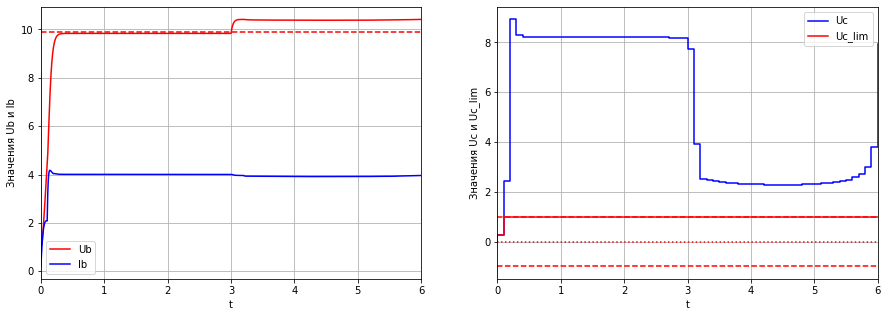

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


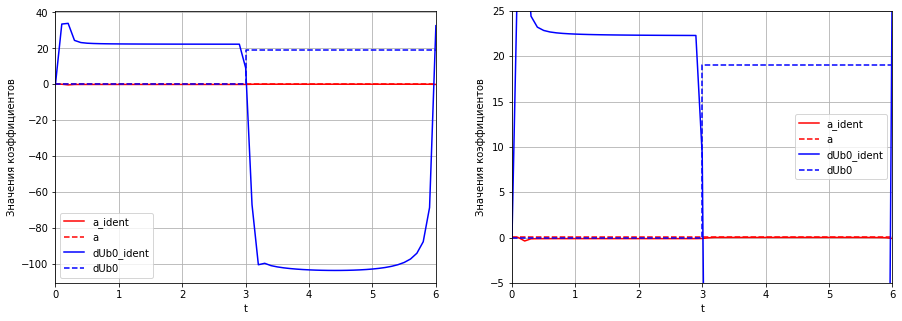

In [ ]:
v0_init = 0
v0_finish = 19.0
change_time = 3
goal = 9.9
gain = 220
step = 1e-1
mod_step = 1e-3
tk = 6
x0 = [1.0, 0.2]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_ident(goal=goal, gain=gain, dt=step)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [0.1, 0.1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
plt.xlim([0, tk])
plt.xlabel('t')
plt.ylabel('Значения коэффициентов')
plt.legend(['a_ident','a','dUb0_ident', 'dUb0'])
plt.grid()
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['a'], 'r', [0, tk], [0.1, 0.1], 'r--',
         reg.coeff['t'], reg.coeff['b'], 'b', [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
plt.ylim([-5.0, 25.0])
plt.xlim([0, tk])
plt.xlabel('t')
plt.ylabel('Значения коэффициентов')
plt.legend(['a_ident','a','dUb0_ident', 'dUb0'])
plt.grid()
plt.show()

На последнем графике приведены значения реальных и идентифицированных коэффициентов системы.
Система имеет статическую ошибку.

# 7.Моделирование САУ с прямой адаптацией



Основной идеей методов, рассматриваемых в этой главе, является прямая настройка коэффициентов регулятора выбранного типа. В данной работе используется линейный регулятор. Ниже рассматривается два способа настройки коэффициентов: на основе обобщенной ошибки и на базе алгоритма скоростного градиента.

## 7.1 Адаптивный регулятор с обобщённой ошибкой настройки

Метод обощенной ошибки адаптации заключается в фильтрации ошибки управления с помощью динамического фильтра. Уравнение фильтра должно отвечать следующим требованиям:


*   Наличие минимума
*   Минимум должен быть единственным
*   Функция J должна быть дифференцируемой

Выберем модель фильтра на основе эталонной модели.


$\frac {d^2e} {dt^2} + 3\frac{de} {dt} + 2e=0$ - эталонная модель

$\frac {d^2e} {dt^2} + 3\frac{de} {dt} + 2e=s$

где e - ошибка управления.

Модель системы:

$\dot Ub = 25Ib - 0.1Ub^3 +dUb_0 - 3e^{-7Ub^2+Ubtanh(7)+tanh(9)}-5$

$\dot Ib = -0.1Ib^3-8Ib^2-2IbUb-2Ib+Ub+30tanh(Uc)-8$

Линейный закон регулирования:

$I = c_1 Ub + c_2 Ib + c_3$

В качестве функционала выбирается квадрат обобщенной ошибки:

$J(s) = s^2$

Из синтеза алгоритма адаптации можно получить выражения для коэффициентов:

$c_{1_k} = c_{1_{k-1}} - GsUb$

$c_{2_k} = c_{2_{k-1}} - GsIb$

$c_{3_k} = c_{3_{k-1}} - Gs$

где $G$ - скорость оптимизации, $s$ - обобщенная ошибка



In [ ]:
class ADCS_gerr(PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_gerr,self).__init__(gain,step=dt)
        self.g = speed
        self.Ubd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'e':[], 'de':[], 'dde':[], 'sigma':[]}
        self.e_last = None
        self.e_last_last = None
        
    def optimize(self, x, t):
        e = x[0] - self.Ubd # вычисляем ошибку
        self.coeff['t'].append(t)
        self.coeff['e'].append(e)
        if self.e_last_last is not None:
            de = (e - self.e_last)/self.dt
            dde = (self.e_last - 2.0*self.e_last + self.e_last_last) / (self.dt**2)
            sigma = dde + 3*de + 2*e # уравнение эталонной модели
            self.coeff['sigma'].append(sigma)

            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]

            c1 = c1 - self.g*sigma*x[0]
            c2 = c2 - self.g*sigma*x[1]
            c3 = c3 - self.g*sigma

            self.coeff['c1'].append(c1)
            self.coeff['c2'].append(c2)
            self.coeff['c3'].append(c3)
        else:
            self.coeff['sigma'].append(0.0)
            self.coeff['c1'].append(self.c10)
            self.coeff['c2'].append(self.c20)
            self.coeff['c3'].append(self.c30)
            
        if self.e_last is not None:
            self.e_last_last = self.e_last
        
        self.e_last = e
    
    def control(self, x, t):
        self.optimize(x, t)
        
        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]
        
        return c1*x[0] + c2*x[1] + c3 # линейны закон общего вида

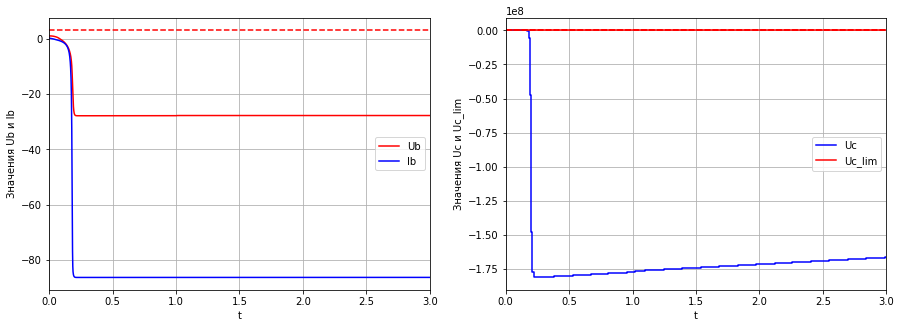

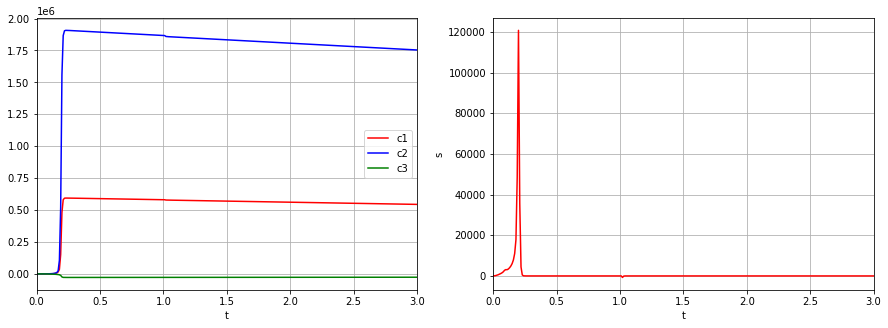

In [ ]:
v0_init = 0
v0_finish = 19
change_time = 1
goal = 3
gain = 5
step = 1e-2
mod_step = 1e-3
tk = 3
x0 = [1.0, 0.2]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_gerr(goal=goal, gain=gain, dt=step, speed=0.1)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',# [0, tk], [-1, -1], 'r--',
         reg.coeff['t'], reg.coeff['c2'], 'b',# [0, change_time, change_time, tk], [v0_init, v0_init, v0_finish, v0_finish], 'b--')
         reg.coeff['t'], reg.coeff['c3'], 'g')
plt.xlim([0, tk])
plt.grid()
plt.legend(['c1','c2','c3'])
plt.xlabel('t')
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['sigma'], 'r')# [0, tk], [-1, -1], 'r--',
plt.xlabel('t')
plt.ylabel('s')
plt.grid()
plt.xlim([0, tk])
plt.show()

## 7.2 Регулятор на базе алгоритма скоростного градиента

Метод на базе алгоритма скоростного градиента основан на оптимизации производной функционала. В отличие от метода обобщенной ошибки расчет коэфициентов регулятора производится с использованием исходной ошибки регулирования.
В качестве функционала выбирается квадрат производной ошибки:

$J(e) = (\frac {d^2e} {dt^2})^2$

Из синтеза алгоритма адаптация получаем выражения для коэффициентов регулятора:

$c_{1_k} = c_{1_{k-1}} - GeUb$

$c_{2_k} = c_{2_{k-1}} - GeIb$

$c_{3_k} = c_{3_{k-1}} - Ge$

где $G$ - скорость оптимизации

Программа расчета управления

In [ ]:
class ADCS_spgrad(PLC):
    def __init__(self, goal, gain, speed, dt): # функция инициализации параметров
        super(ADCS_spgrad,self).__init__(gain, dt)
        self.g = speed
        self.Ubd = goal
        self.dt = dt
        self.c10 = 0.0
        self.c20 = 0.0
        self.c30 = 0.0
        self.coeff = {'t':[], 'c1':[], 'c2':[], 'c3':[], 'e':[], 'Q':[]}
        
    def optimize(self, x, t):
        e = x[0] - self.Ubd
        Q = e**2
        
        self.coeff['t'].append(t)
        self.coeff['e'].append(e)
        self.coeff['Q'].append(Q)

        if len(self.coeff['c1'])>0:
            c1 = self.coeff['c1'][-1]
            c2 = self.coeff['c2'][-1]
            c3 = self.coeff['c3'][-1]
        else:
            c1 = 0.0
            c2 = 0.0
            c3 = 0.0

        c1 = c1 - self.g*e*x[0]
        c2 = c2 - self.g*e*x[1]
        c3 = c3 - self.g*e

        self.coeff['c1'].append(c1)
        self.coeff['c2'].append(c2)
        self.coeff['c3'].append(c3)
    
    def control(self, x, t):
        self.optimize(x, t)
        
        c1 = self.coeff['c1'][-1]
        c2 = self.coeff['c2'][-1]
        c3 = self.coeff['c3'][-1]
        
        return c1*x[0] + c2*x[1] + c3

Моделирование системы с регулятором

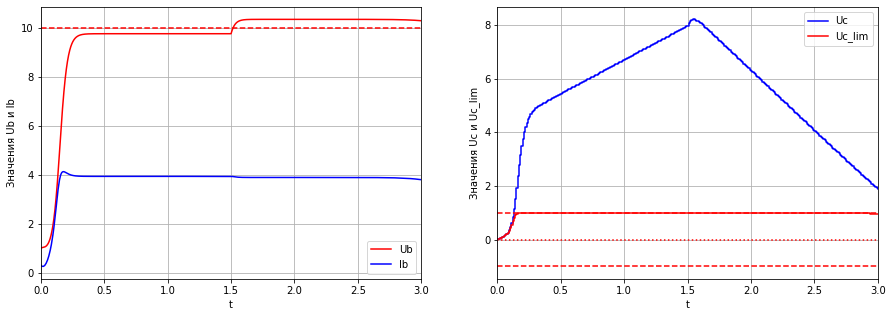

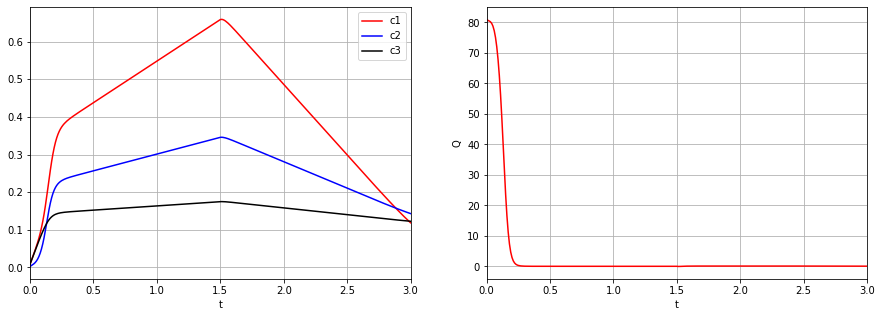

In [ ]:
v0_init = 0
v0_finish = 19
change_time = 1.5
goal = 10
gain = 213
step = 1e-2
mod_step = 1e-3
tk = 3
x0 = [1, 0.3]
func_ctrl = F_with_change(change_time,v0_init,v0_finish)

reg = ADCS_spgrad(goal=goal, gain=gain, dt=step, speed=0.001)
res = calculate(func_ctrl, x0, mod_step, tk, reg)
plot_result(time=res['t'], time_end=tk, x1 = res['x1'], x2 = res['x2'], plc=reg, goal=goal)

tend = tk
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(reg.coeff['t'], reg.coeff['c1'], 'r',
         reg.coeff['t'], reg.coeff['c2'], 'b',
         reg.coeff['t'], reg.coeff['c3'], 'k')
plt.xlim([0, tk])
plt.grid()
plt.legend(['c1','c2','c3'])
plt.xlabel('t')
plt.subplot(1,2,2)
plt.plot(reg.coeff['t'], reg.coeff['Q'], 'r')
plt.grid()
plt.xlabel('t')
plt.ylabel('Q')
plt.xlim([0, tk])
plt.show()

# ЗАКЛЮЧЕНИЕ

В ходе выполнения курсовой работы был изучен метод аналитического конструирования агрегированных регуляторов(АКАР), а также способо его практического применения. Изучен принцип настройки коэффициентов регулятора с использованием обобщенной ошибки регулирования и метода скоростного градиента При помощи языка программирования Python были разработаны и промоделированы систем управления с адаптацией к неконтролируемому возмущению согласно следующему перечню методов:

*   метод АКАР с интегральной адаптацией
*   метод АКАР с идентификацией неизмеряемого параметра
*   система прямого адаптивного управления с обобщённой ошибкой настройки
*   система прямого адаптивного управления на основе метода скоростного градиента
